In [ ]:
## Train the model using PyTorch

In [2]:
import os
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import numpy as np 
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline

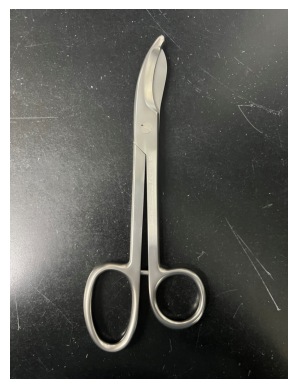

image shape: (4032, 3024, 3)


In [46]:
# Load a image
img_path = "dataset\\data-splited 3\\train\\Ciseaux à plâtre\\Ciseaux à plâtre.jpg"

with Image.open(img_path) as img:
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
    print("image shape:", np.array(img).shape)

> Using __torchvision.transforms V2__ it's faster and they can do more things. [docs link](https://pytorch.org/vision/stable/transforms.html)

In [15]:
# Path directory
dir_path = "dataset/data-splited 3"

# Data augmentation transformations (only train set)
train_transform = v2.Compose([
    v2.ToImage(),  # Convert to tensor
    v2.Resize((224, 224)),  # Resize image
    v2.RandomRotation(20),   # Random rotation
    v2.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    # Add more transformations if needed
    v2.ToDtype(torch.float32, scale=True),
    # Normalize using Imagenet pretrianed model with its own mean and std is recommended.
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

# Data augmentation transformations for val and test sets
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

# Load dataset
train_set = ImageFolder(os.path.join(dir_path, "train"), transform=train_transform)
val_set = ImageFolder(os.path.join(dir_path, "val"), transform=transform)
test_set = ImageFolder(os.path.join(dir_path, "test"), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [35]:
train_set.class_to_idx

{'Ciseaux Mayo': 0,
 'Ciseaux Stevens': 1,
 'Ciseaux Stille': 2,
 'Ciseaux micro': 3,
 'Ciseaux à plâtre': 4}

In [11]:
num_classes = len(train_set.classes) 
print("Number of classes:", num_classes)

5


In [12]:
num_images = len(train_set.imgs)
print("Number of images for train set: ", num_images)

Number of images for train set:  186


1. Batching

- Efficient Training: DataLoaders group your data into mini-batches. This is essential for training deep learning models because, instead of processing one massive dataset at once, models update their weights from smaller batches, speeding up training and improving memory efficiency.
- Batch Size as a Hyperparameter: You control the batch size, which becomes a tunable aspect of your model's training process.

2. Shuffling

- Preventing Overfitting: DataLoaders can shuffle your data between epochs (complete passes through your training data). This helps prevent the model from overfitting by ensuring it sees the data in different orders during each training cycle.

3. Data Transformation 
- (On-the-fly) Data Augmentation: While you often define most of your transformations beforehand (transforms.Compose), DataLoaders can apply simple transformations as the data is being loaded into batches. This allows for on-the-fly data augmentation to further improve generalization.

4. Parallel Loading

- Speeding Things Up: DataLoaders can utilize multiple CPU cores through the num_workers argument. This means pre-processing and loading batches of data happens in parallel with model training on the GPU, reducing idle time and improving overall training speed.

In [37]:
# Extract one images and labels from train_set
for image, label in train_set:
    break

In [38]:
image.shape

torch.Size([3, 224, 224])

In [6]:
train_set.classes

['Ciseaux Mayo',
 'Ciseaux Stevens',
 'Ciseaux Stille',
 'Ciseaux micro',
 'Ciseaux à plâtre']

In [24]:
def rescale_image(image):
    min_val = image.min()
    max_val = image.max()
    return (image - min_val) / (max_val - min_val)


img_rescaled = rescale_image(image)
print(img_rescaled.min(), img_rescaled.max()) 

tensor(0.) tensor(1.)


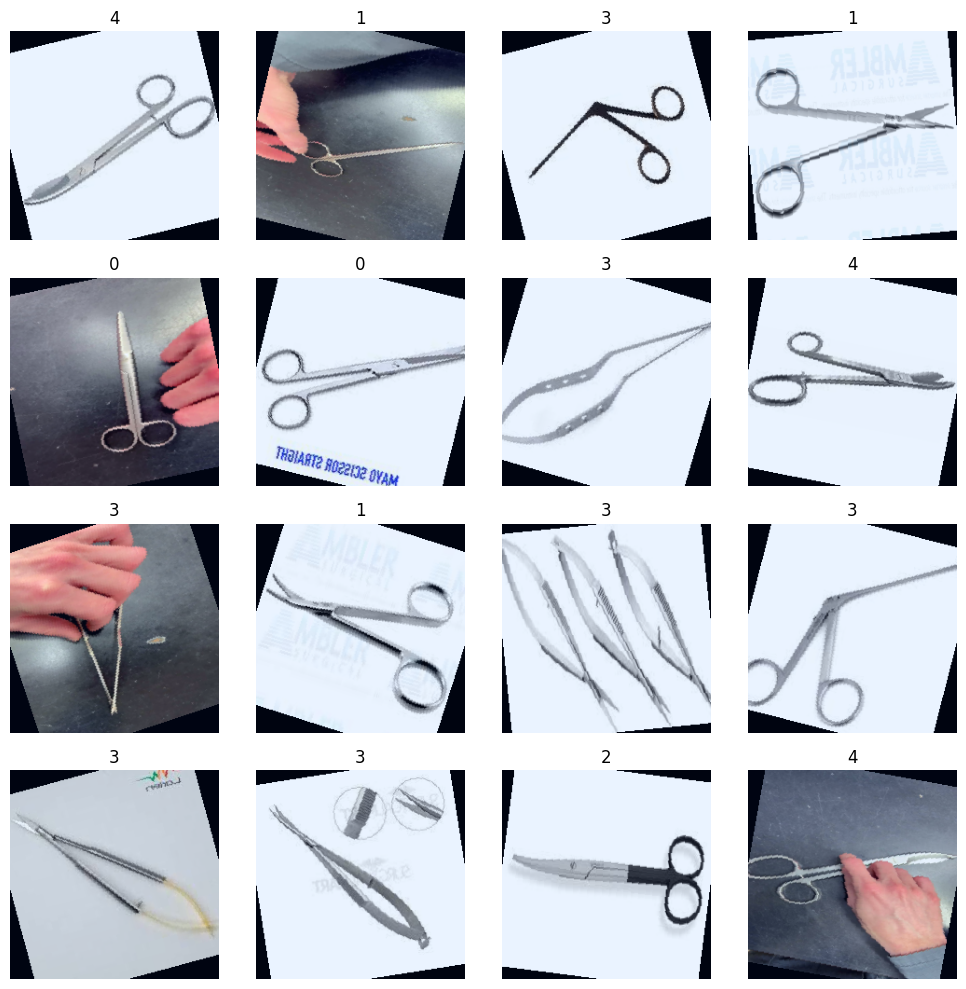

In [13]:
def rescale_image(image):
    min_val = image.min()
    max_val = image.max()
    return (image - min_val) / (max_val - min_val)


# Extract a batch of images and labels from train_set
for images, labels in train_loader:
    break


fig, axs =  plt.subplots(4,4, figsize=(10,10))

for i, ax in zip(range(16), axs.ravel()):
    img = rescale_image(images[i]) # Shift to 0-1 range
    ax.imshow(img.permute(1, 2, 0)) #  Reorders the image tensor dimensions
    ax.axis('off')
    ax.set_title(labels[i].item())
plt.tight_layout()
plt.show()

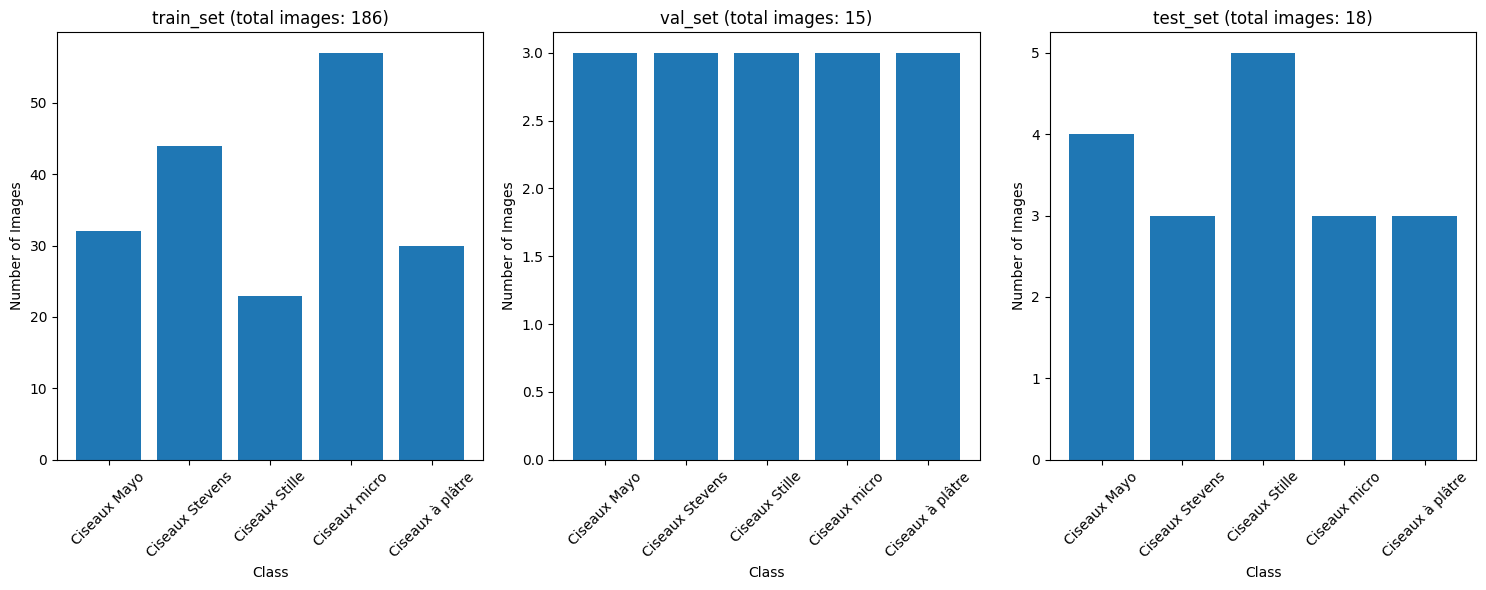

In [14]:
import collections
import matplotlib.pyplot as plt

def get_class_counts(dataset):
    class_counts = collections.defaultdict(int)  
    for _, label in dataset:
        class_counts[dataset.classes[label]] += 1
    return class_counts 


# Apply to each dataset
train_counts = get_class_counts(train_set)
val_counts = get_class_counts(val_set)
test_counts = get_class_counts(test_set)

# Plotting
set_names = ["train_set", "val_set", "test_set"]
counts_list = [train_counts, val_counts, test_counts] 

fig, axes = plt.subplots(1, 3, figsize=(15, 6))  # Adjusted figsize

for set_name, counts, ax in zip(set_names, counts_list, axes.ravel()):
    ax.bar(counts.keys(), counts.values())  # Plot directly from the dictionary
    ax.set_title(f"{set_name} (total images: {sum(counts.values())})")
    ax.set_xlabel("Class")  # More descriptive label
    ax.set_ylabel("Number of Images")
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()


3. Custom Classification Layers

- ``x.size(0)`` : Returns the size of the 0th dimension, which is the __batch size__ (i.e., how many samples are in that batch).
- ``x.size(1)`` : Returns the __size of the 1st dimension__. The meaning of this dimension depends on the context of the tensor x. After applying ``x.view...``, this represents the __total number of features__ resulting from the flattening operation.  

1. Loading the Pre-trained Model

In [10]:
for images, labels in train_loader:
    break 

print("tensor shape:", images.shape) 

tensor shape: torch.Size([16, 3, 224, 224])


### Example of loading and summarising a pre-train mode

In [98]:
from torchsummary import summary
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

mod = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
summary(mod.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

## Define a simple model (not use as train model)
__``super()`` gives you a way to access methods and properties from a class's parent (or superclass).__

``super(NeuralNetwork).__init__()`` specifically does the following:

Finds the parent class of NeuralNetwork (which is nn.Module)
Calls the __init__() method (constructor) of the parent class to make sure the necessary initialization steps of the nn.Module are performed within the NeuralNetwork object.

In [104]:
from torchsummary import summary
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import torch.nn as nn 

class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=len(train_set.classes)):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        for param in self.base_model.parameters():
            param.requires_grad = False  # Freeze all layers initially

        mob_out_size = 62720
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(mob_out_size, num_classes),
            nn.Softmax(dim=1) 
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output
    
    
model = SimpleCardClassifer(len(train_set.classes))
print(str(model)[-500:])



ps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (18): Conv2dNormActivation(
        (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=62720, out_features=5, bias=True)
    (2): Softmax(dim=1)
  )
)


In [105]:
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
            Conv2d-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
       BatchNorm2d-4         [-1, 32, 112, 112]              64
             ReLU6-5         [-1, 32, 112, 112]               0
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]             288
            Conv2d-8         [-1, 32, 112, 112]             288
       BatchNorm2d-9         [-1, 32, 112, 112]              64
      BatchNorm2d-10         [-1, 32, 112, 112]              64
            ReLU6-11         [-1, 32, 112, 112]               0
            ReLU6-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
           Conv2d-14         [-1, 16, 1

## Check is model works

In [15]:
# Extract one images and labels from train_set
for image, label in train_set:
    break

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model(image.unsqueeze(0).to(device))

tensor([[0.1925, 0.0931, 0.1386, 0.2409, 0.3349]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

this model works!!

## Remove model , device and clean cuda 

In [33]:

import gc

del model
del device
""" gc.collect()  """

' gc.collect()  '

In [34]:
## Empty cuda cache (GPU)
torch.cuda.empty_cache()

## Define the training model

In [40]:
from torchsummary import summary
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import torch.nn as nn 

class NeuralNetwork(nn.Module):
    def __init__(self, num_classes=len(train_set.classes)):
        super(NeuralNetwork, self).__init__()
        # Where we define all the parts of the model
        self.base_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        # Code the of the base model
        #for param in self.base_model.parameters():
        #    param.requires_grad = False  # Freeze all layers initially
        self.fine_tune_at = 154

        # Iterate through parameters, not layers directly
        for i, param in enumerate(self.base_model.parameters()):
            if i >= self.fine_tune_at: 
                param.requires_grad = True  # Unfreeze parameters
            else:
                param.requires_grad = False

      
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # More flexible than GlobalAveragePooling
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(1280, 1024),  # Adjust input features
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1) 
        )
        
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output
    
    
model = NeuralNetwork(len(train_set.classes))

summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
            Conv2d-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
       BatchNorm2d-4         [-1, 32, 112, 112]              64
             ReLU6-5         [-1, 32, 112, 112]               0
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]             288
            Conv2d-8         [-1, 32, 112, 112]             288
       BatchNorm2d-9         [-1, 32, 112, 112]              64
      BatchNorm2d-10         [-1, 32, 112, 112]              64
            ReLU6-11         [-1, 32, 112, 112]               0
            ReLU6-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
           Conv2d-14         [-1, 16, 1

### Check model

In [68]:
# Extract one images and labels from train_set
for image, label in train_set:
    break

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
test_output = model(image.unsqueeze(0).to(device))
test_output 

tensor([[0.1960, 0.2070, 0.2427, 0.2122, 0.1421]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

Yes it works.
Next, setup the loss and theoptimizer.

In [43]:
# Loss function
loss = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 



In [60]:
# Python library designed to display visually appealing progress bars. """ I'm not using it """
from tqdm.notebook import tqdm

## Training loop

In [41]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Simple training loop
num_epochs = 100
train_losses, val_losses = [], []
train_accuracys, val_accuracys = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = NeuralNetwork(len(train_set.classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

reduce_lr_callback = ReduceLROnPlateau(optimizer, factor=0.5, patience=3, mode='min')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for images, labels in train_loader:
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Update the running total of correct predictions and samples
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    
    # Calculate the accuracy and the loss for this epoch
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * total_correct / total_samples
    
    # Save accuracy and loss
    train_losses.append(train_loss)
    train_accuracys.append(train_accuracy)
    
    
    ### Validation phase
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
        
            # Update the running total of correct predictions and samples
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
 
    # Calculate the accuracy and the loss for this epoch
    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = 100 * total_correct / total_samples
    
    # Save accuracy and loss
    val_losses.append(val_loss)
    val_accuracys.append(val_accuracy)
    
    # Rrint results
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.2f}%, Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")

    # Reduce learning rate on plateau
    reduce_lr_callback.step(val_loss)
    

Epoch 1/100 - Train loss: 1.5932, Train accuracy: 29.03%, Validation loss: 1.6330, Validation accuracy: 20.00%
Epoch 2/100 - Train loss: 1.5005, Train accuracy: 36.02%, Validation loss: 1.5953, Validation accuracy: 13.33%
Epoch 3/100 - Train loss: 1.4294, Train accuracy: 47.31%, Validation loss: 1.6125, Validation accuracy: 20.00%
Epoch 4/100 - Train loss: 1.3610, Train accuracy: 51.61%, Validation loss: 1.4535, Validation accuracy: 40.00%
Epoch 5/100 - Train loss: 1.3033, Train accuracy: 56.99%, Validation loss: 1.4112, Validation accuracy: 66.67%
Epoch 6/100 - Train loss: 1.2879, Train accuracy: 65.05%, Validation loss: 1.4872, Validation accuracy: 46.67%
Epoch 7/100 - Train loss: 1.3116, Train accuracy: 56.45%, Validation loss: 1.3207, Validation accuracy: 53.33%
Epoch 8/100 - Train loss: 1.2605, Train accuracy: 65.05%, Validation loss: 1.2801, Validation accuracy: 73.33%
Epoch 9/100 - Train loss: 1.3125, Train accuracy: 59.68%, Validation loss: 1.3495, Validation accuracy: 53.33%
E

>**Note**<br><br>
The loss is height 1.00~ I need to check that still.

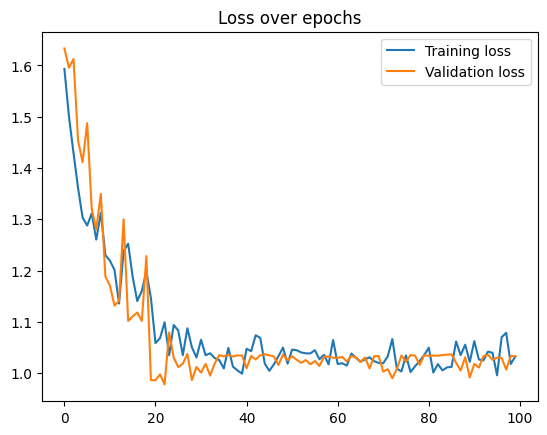

In [42]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

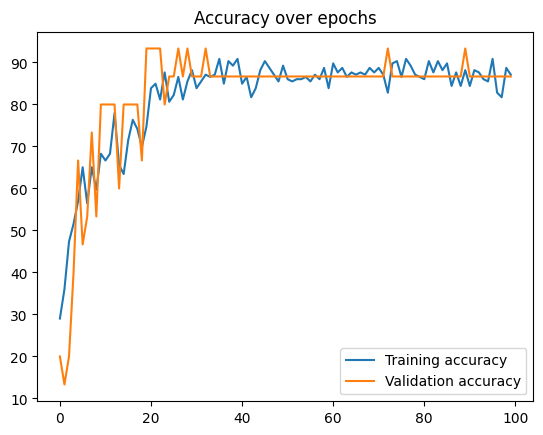

In [43]:
plt.plot(train_accuracys, label='Training accuracy')
plt.plot(val_accuracys, label='Validation accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

## Test the model on the test-set

In [39]:
def evaluate(model, test_loader):
  # Set model to evaluation mode
  model.eval()

  # Track total loss and number of correct predictions
  total_loss = 0
  correct_predictions = 0

  # No gradient calculation needed during evaluation
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)  # Move to device (CPU/GPU)
      output = model(data)  # Get model predictions
      # Calculate loss (e.g., cross-entropy loss for classification)
      loss = criterion(output, target)
      total_loss += loss.item()  # Accumulate loss

      # Calculate accuracy (specific metric depends on task)
      # For classification:
      _, predicted = torch.max(output.data, 1)  # Get predicted class labels
      correct_predictions += (predicted == target).sum().item()

  # Calculate average loss and accuracy
  average_loss = total_loss / len(test_loader.dataset)
  accuracy = correct_predictions / len(test_loader.dataset)

  # Print or return evaluation metrics (loss, accuracy)
  print(f"Test Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
  return average_loss, accuracy

evaluate(model, test_loader)

Test Loss: 0.1109, Accuracy: 0.8889


(0.11085785097546047, 0.8888888888888888)

In [152]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
base_model.features.0.0.weight 	 torch.Size([32, 3, 3, 3])
base_model.features.0.1.weight 	 torch.Size([32])
base_model.features.0.1.bias 	 torch.Size([32])
base_model.features.0.1.running_mean 	 torch.Size([32])
base_model.features.0.1.running_var 	 torch.Size([32])
base_model.features.0.1.num_batches_tracked 	 torch.Size([])
base_model.features.1.conv.0.0.weight 	 torch.Size([32, 1, 3, 3])
base_model.features.1.conv.0.1.weight 	 torch.Size([32])
base_model.features.1.conv.0.1.bias 	 torch.Size([32])
base_model.features.1.conv.0.1.running_mean 	 torch.Size([32])
base_model.features.1.conv.0.1.running_var 	 torch.Size([32])
base_model.features.1.conv.0.1.num_batches_tracked 	 torch.Size([])
base_model.features.1.conv.1.weight 	 torch.Size([16, 32, 1, 1])
base_model.features.1.conv.2.weight 	 torch.Size([16])
base_model.features.1.conv.2.bias 	 torch.Size([16])
base_model.features.1.conv.2.running_mean 	 torch.Size([16])
base_model.features.1.conv.2.running_var 	 tor

In [44]:
torch.save(model, 'pytorch-model.pt')  

## Using the model for inference

### 1. load the model

In [47]:
# Load model
saved_model = torch.load('pytorch-model.pt')

summary(saved_model, (3, 224, 224))# Load model
saved_model = torch.load('pytorch-model.pt')

summary(saved_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
            Conv2d-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
       BatchNorm2d-4         [-1, 32, 112, 112]              64
             ReLU6-5         [-1, 32, 112, 112]               0
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]             288
            Conv2d-8         [-1, 32, 112, 112]             288
       BatchNorm2d-9         [-1, 32, 112, 112]              64
      BatchNorm2d-10         [-1, 32, 112, 112]              64
            ReLU6-11         [-1, 32, 112, 112]               0
            ReLU6-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
           Conv2d-14         [-1, 16, 1

### 2. Loading an Image

In [49]:
def load_image(image_path):
    """Loads an image, converts to RGB format (if needed), and resizes it."""

    with Image.open(image_path) as image:

        # Ensure RGB format (some images could be grayscale)
        image = image.convert('RGB')

    return image

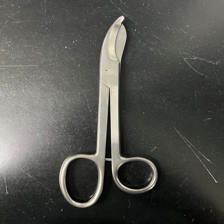

In [52]:
img = load_image(img_path)
display(img.resize((224, 224)))

### Normalization (using mean and std of model pretrianed on Imagenet)



In [56]:
def normalize_image(image):
    """Converts the image to a tensor, resize  and normalizes it."""

    transform = v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224)),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image)

img_tensor = normalize_image(img)
print("tensor shape:", img_tensor.shape)

tensor shape: torch.Size([3, 224, 224])


### 4. Using the Image with a PyTorch Model

In [63]:
def predict(model, image_path):
    """Processes the image and gets prediction from the model."""

    # Load and prepare the image
    image = load_image(image_path)  
    image_tensor = normalize_image(image)

    # Add an extra batch dimension (PyTorch models expect a batch)
    image_tensor = image_tensor.unsqueeze(0)
     
    # Set the CUDA-compatible GPU if available 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    
    # Move the model to the selected device
    model.to(device) 

    # Move a tensor to the selected device
    image_tensor = image_tensor.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Get the prediction (output will be raw model output)
    output = model(image_tensor)
    
    ### Note the prediction ouput is softmax
    
    # This means data is first moved to cpu and then converted to numpy array.
    index = output.cpu().data.numpy().argmax()

    # Process the output according to your model's task 
    #  (e.g., apply softmax if doing classification)
    return index


## Run the model

In [68]:
index = predict(model, img_path)
index

4

In [73]:
train_set.class_to_idx

{'Ciseaux Mayo': 0,
 'Ciseaux Stevens': 1,
 'Ciseaux Stille': 2,
 'Ciseaux micro': 3,
 'Ciseaux à plâtre': 4}

In [76]:
class_dict = {index: name for name, index in train_set.class_to_idx.items()}
class_dict

{0: 'Ciseaux Mayo',
 1: 'Ciseaux Stevens',
 2: 'Ciseaux Stille',
 3: 'Ciseaux micro',
 4: 'Ciseaux à plâtre'}

In [77]:
class_dict[index]

'Ciseaux à plâtre'

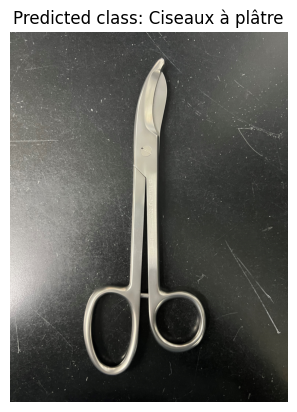

In [83]:
def get_name(model, image_path):
    index = predict(model, image_path)
    class_name = class_dict[index]
    
    # show image
    img = load_image(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted class: {class_name}")
    plt.show()
   
   
# Here I'm using the save_model  
get_name(saved_model, img_path)